### Notes:
- train only on the elements in the material?

In [1]:
import numpy as np
from sklearn import linear_model, model_selection, metrics

import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../src/")
from material import Material
from materialsdataset import MaterialsDataset
from periodictable import PeriodicTable
from materialspredictiondata import MaterialsPredictionData
from bandgappredictions import BandGapPredictions

In [2]:
csv_path = "../data/training/materialsproject_output/"
json_path = "../data/training/materialsproject_json/"

### MaterialsPredictionData class
- the user creates an object of this type to use the package
- takes in a MaterialsDatset type object which contains materials and their params to use for prediction
- houses array of data to run through the model to predict the bandgap
- also houses information needed to create the correct training data based on the user input

In [3]:
Cd22S45 = Material(formula="Cd22S45",density=2.34)
Si3Ge4 = Material(formula="Si3Ge4",density=1.23,volume=57)
SiGe = Material(formula="SiGe",density=3.824,volume=43.741,formation_energy=0.024,
                crystal_system="cubic",spacegroup="F43m",E_above_hull=0.024,Nsites=2) #taken from mp-1219182

print(Cd22S45.training_params)
print(Si3Ge4.training_params)
print(SiGe.training_params)

['density__gm_per_cc']
['volume', 'density__gm_per_cc']
['spacegroup', 'formation_energy__eV', 'E_above_hull__eV', 'volume', 'Nsites', 'density__gm_per_cc', 'crystal_system']


In [4]:
materials_dataset = MaterialsDataset([Cd22S45,Si3Ge4,SiGe])

In [5]:
materials_dataset.materials_dict["SiGe"]

{'params': {'spacegroup': 'F43m',
  'formation_energy__eV': 0.024,
  'E_above_hull__eV': 0.024,
  'volume': 43.741,
  'Nsites': 2,
  'density__gm_per_cc': 3.824,
  'crystal_system': 'cubic'},
 'stoichiometry': {'Si': 0.5, 'Ge': 0.5}}

In [6]:
periodic_table = PeriodicTable()
symbol_to_element_map = periodic_table.symbol_to_element_map
symbols = periodic_table.symbols

In [7]:
materials_prediction_data = MaterialsPredictionData(materials_dataset,symbols)

In [8]:
print(materials_prediction_data.prediction_data["SiGe"])

['F43m', 0.024, 0.024, 43.741, 2, 3.824, 'cubic', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
materials_to_predict = list(materials_prediction_data.prediction_data.keys())
materials_to_predict

['Cd22S45', 'Si3Ge4', 'SiGe']

### BandGapPredictions class
- prediction made for each material
- unique model is trained for each material, as each material can have unique input parameters

In [10]:
band_gap_predictions = BandGapPredictions(
    materials_to_predict=materials_to_predict,
    csv_path=csv_path,
    json_path=json_path,
    symbols=symbols,
    materials_dataset=materials_dataset,
    materials_prediction_data=materials_prediction_data
)
predictions = band_gap_predictions.predictions

In [11]:
for material in band_gap_predictions.materials_to_predict:
    material_model_score = predictions[material]["model_score"]
    material_predicted_band_gap = predictions[material]["band_gap__eV"]
    print(f""" 
    {material}
    -----------
    model score: {material_model_score}
    band gap: {material_predicted_band_gap} eV""")

 
    Cd22S45
    -----------
    model score: 0.34312591695290784
    band gap: 1.4839312525621762 eV
 
    Si3Ge4
    -----------
    model score: 0.4043276706489519
    band gap: 1.129270061666682 eV
 
    SiGe
    -----------
    model score: 0.5122836130820076
    band gap: 0.9718261093918189 eV


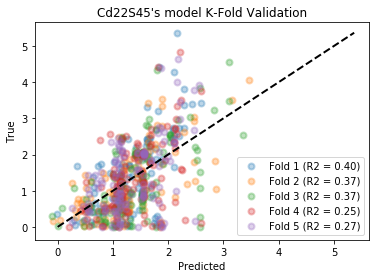

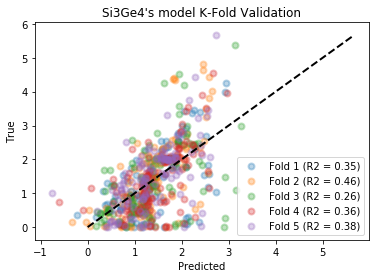

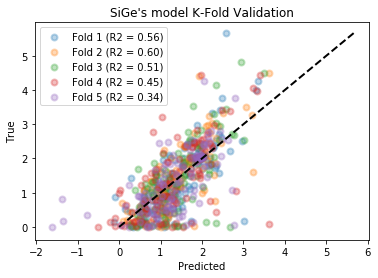

In [14]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material in band_gap_predictions.materials_to_predict:
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = predictions[material]["X_train"]
    y_train = predictions[material]["y_train"]
    model = predictions[material]["model"]
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
plt.show()